**whenever Claude wants to use a tool, it already responds using the perfectly structured format we told it to use when we defined the tool.**

# Conceptual overview

In this lesson, we're going to "trick" Claude by telling it about a particular tool, but we won't need to actually call the underlying tool function.  We're using the tool as a way of forcing a particular structure of response, as seen in this diagram:

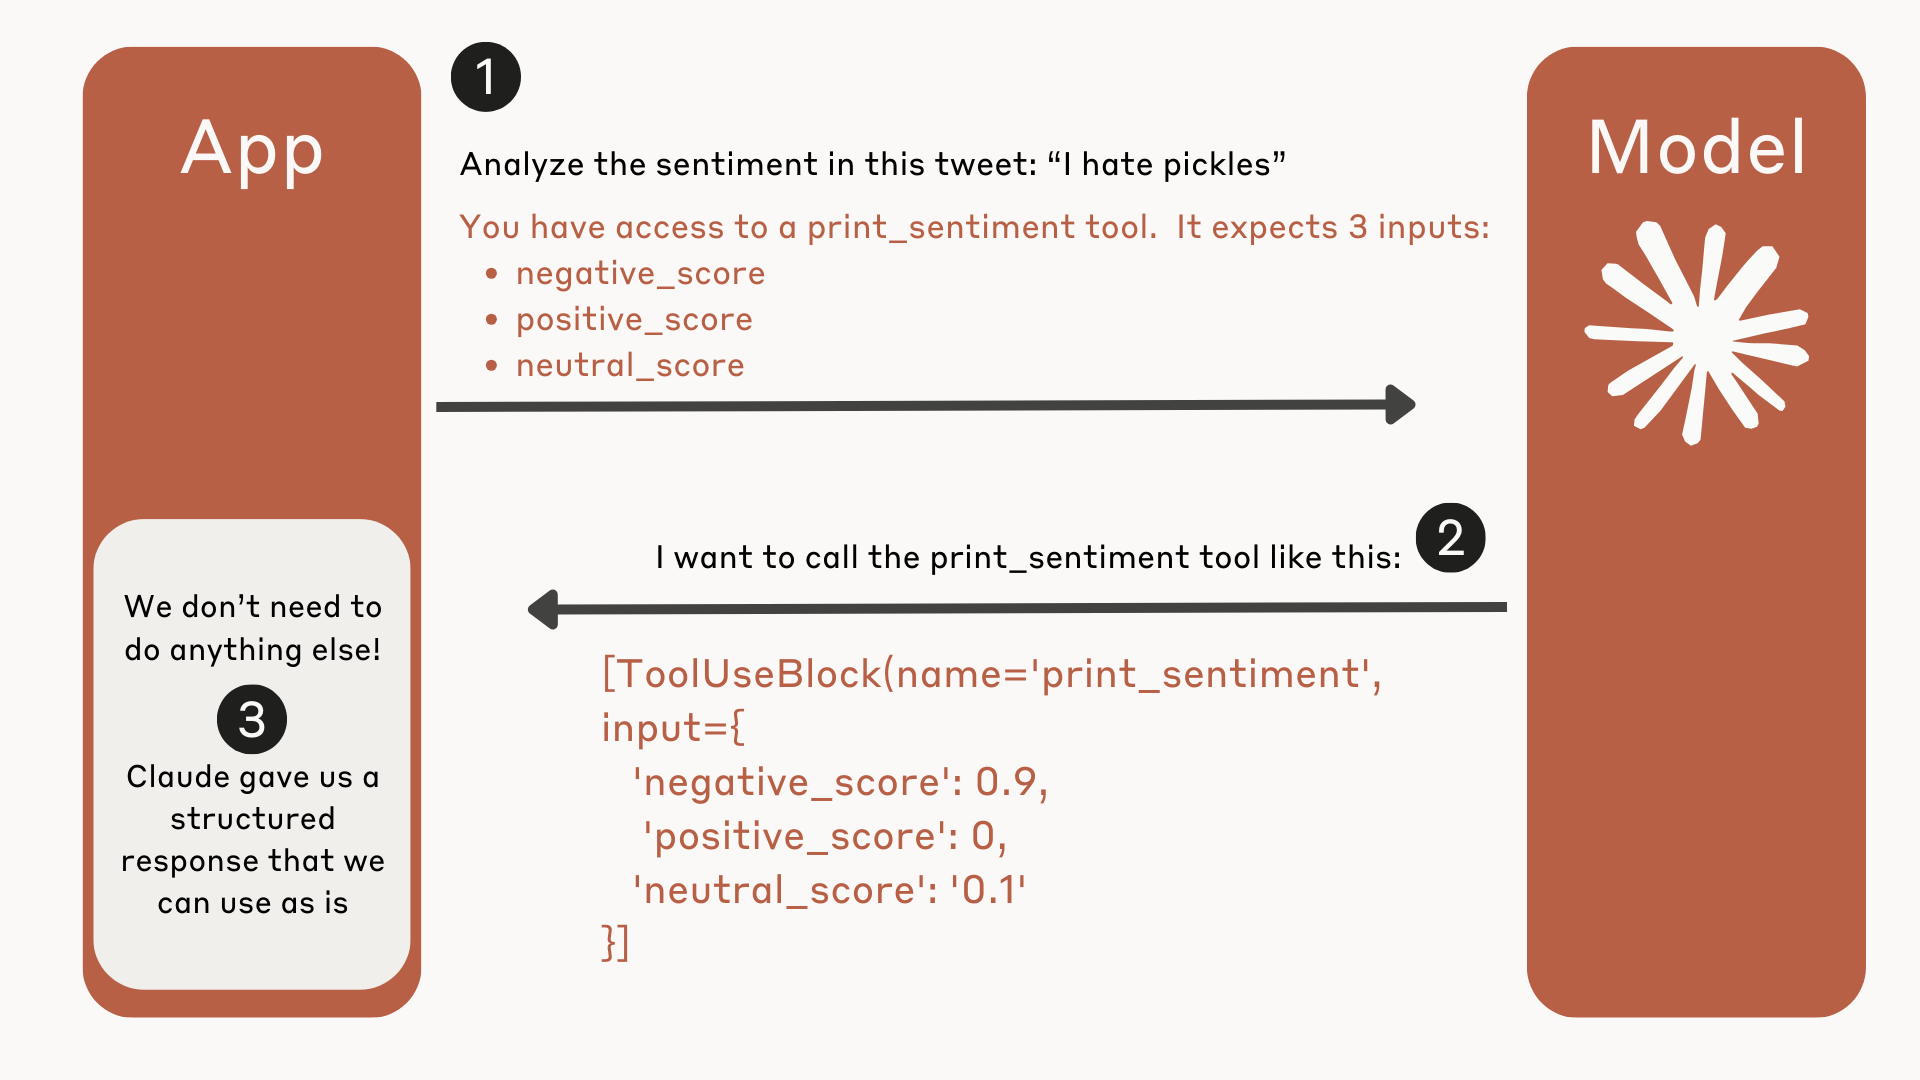

## Sentiment analysis
Let's start with a simple example.  Suppose we want Claude to analyze the sentiment in some text and respond with a JSON object that follows this shape: 

```
{
  "negative_score": 0.6,
  "neutral_score": 0.3,
  "positive_score": 0.1
}
```

All we have to do is define a tool that captures this shape using JSON Schema.  Here's a potential implementation: 

In [1]:
tools = [
    {
        "toolSpec": {

        "name": "print_sentiment_scores",
        "description": "Prints the sentiment scores of a given text.",
        "inputSchema": {
            "json": {

                "type": "object",
                "properties": {
                    "positive_score": {"type": "number", "description": "The positive sentiment score, ranging from 0.0 to 1.0."},
                    "negative_score": {"type": "number", "description": "The negative sentiment score, ranging from 0.0 to 1.0."},
                    "neutral_score": {"type": "number", "description": "The neutral sentiment score, ranging from 0.0 to 1.0."}
                },
                "required": ["positive_score", "negative_score", "neutral_score"]
            }
        }
        }
    }
]

Now we can tell Claude about this tool and explicitly tell Claude to use it, to ensure that it actually does use it.  We should get a response telling us that Claude wants to use a tool.  The tool use response should contain all the data in the exact format we want.

In [2]:
import boto3

bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

tweet = "I'm a HUGE hater of pickles.  I actually despise pickles.  They are garbage."

query = f"""
<text>
{tweet}
</text>

Only use the print_sentiment_scores tool.
"""

messages = [{
    "role": "user",
    "content": [{"text": query}]
}]

inference_config={"maxTokens":400}
tool_config = {"tools":tools}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    inferenceConfig=inference_config,
    toolConfig=tool_config,
)

In [3]:
response["output"]["message"]["content"]

[{'text': 'I\'ll help you analyze the sentiment of this text about pickles using the print_sentiment_scores tool. Based on the strong negative language used ("HUGE hater," "despise," "garbage"), this appears to be a very negative statement.'},
 {'toolUse': {'toolUseId': 'tooluse_QVZ2pwyORuuWI4eiYwrU1A',
   'name': 'print_sentiment_scores',
   'input': {'positive_score': 0.0,
    'negative_score': 0.9,
    'neutral_score': 0.1}}}]

In [4]:
import json
json_sentiment = None
for content in response["output"]["message"]["content"]:
    if content.get("toolUse") is not None and content["toolUse"]["name"] == "print_sentiment_scores":
        json_sentiment = content["toolUse"]["input"]
        break

if json_sentiment:
    print("Sentiment Analysis (JSON):")
    print(json.dumps(json_sentiment, indent=2))
else:
    print("No sentiment analysis found in the response.")

Sentiment Analysis (JSON):
{
  "positive_score": 0.0,
  "negative_score": 0.9,
  "neutral_score": 0.1
}


It works! Now let's turn that into a reusable function that takes a tweet or article and then prints or returns the sentiment analysis as JSON.

In [5]:


def analyze_sentiment(content):

    query = f"""
    <text>
    {content}
    </text>

    Only use the print_sentiment_scores tool.
    """

    messages = [{
        "role": "user",
        "content": [{"text": query}]
    }]

    inference_config={"maxTokens":400}
    tool_config = {"tools":tools}

    # Send the message.
    response = bedrock_client.converse(
        modelId=model_id,
        messages=messages,
        inferenceConfig=inference_config,
        toolConfig=tool_config,
    )

    json_sentiment = None
    for content in response["output"]["message"]["content"]:
        if content.get("toolUse") is not None and content["toolUse"]["name"] == "print_sentiment_scores":
            json_sentiment = content["toolUse"]["input"]
            break

    if json_sentiment:
        print("Sentiment Analysis (JSON):")
        print(json.dumps(json_sentiment, indent=2))
    else:
        print("No sentiment analysis found in the response.")

In [6]:
analyze_sentiment("OMG I absolutely love taking bubble baths soooo much!!!!")

Sentiment Analysis (JSON):
{
  "positive_score": 0.9,
  "negative_score": 0.0,
  "neutral_score": 0.1
}


In [7]:
analyze_sentiment("Honestly I have no opinion on taking baths")

Sentiment Analysis (JSON):
{
  "positive_score": 0.0,
  "negative_score": 0.0,
  "neutral_score": 1.0
}


***

## Forcing tool use with `tool_choice` 

Currently we're "forcing" Claude to use our `print_sentiment_scores` tool through prompting.  In our prompt, we write `Only use the print_sentiment_scores tool.` which usually works, but there's a better way! We can actually force Claude to use a specific tool using the `tool_choice` parameter:

In [8]:
tool_choice={"type": "tool", "name": "print_sentiment_scores"}

The above code tells Claude that it must respond by calling the `print_sentiment_scores` tool.  Let's update our function to use it:

In [9]:


def analyze_sentiment(content):

    query = f"""
    <text>
    {content}
    </text>

    Only use the print_sentiment_scores tool.
    """

    messages = [{
        "role": "user",
        "content": [{"text": query}]
    }]

    inference_config={"maxTokens":400}
    tool_config = {"tools":tools, "tool" : {"name" : "top_song"}}

    # Send the message.
    response = bedrock_client.converse(
        modelId=model_id,
        messages=messages,
        inferenceConfig=inference_config,
        toolConfig=tool_config,
    )

    json_sentiment = None
    for content in response["output"]["message"]["content"]:
        if content.get("toolUse") is not None and content["toolUse"]["name"] == "print_sentiment_scores":
            json_sentiment = content["toolUse"]["input"]
            break

    if json_sentiment:
        print("Sentiment Analysis (JSON):")
        print(json.dumps(json_sentiment, indent=2))
    else:
        print("No sentiment analysis found in the response.")


We'll cover `tool_choice` in greater detail in an upcoming lesson.

***

## Entity extraction example

Let's use this same approach to get Claude to generate nicely formatted JSON that contains entities like people, organizations, and locations extracted from a text sample:


In [10]:
import json

tools = [
    {
        "toolSpec": {
            "name": "print_entities",
            "description": "Prints extract named entities.",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "entities": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "name": {"type": "string", "description": "The extracted entity name."},
                                    "type": {"type": "string", "description": "The entity type (e.g., PERSON, ORGANIZATION, LOCATION)."},
                                    "context": {"type": "string", "description": "The context in which the entity appears in the text."}
                                },
                                "required": ["name", "type", "context"]
                            }
                        }
                    },
                    "required": ["entities"]
                }
            }
        }
    }
]

text = "John works at Google in New York. He met with Sarah, the CEO of Acme Inc., last week in San Francisco."

query = f"""
<document>
{text}
</document>

Use the print_entities tool.
"""

messages = [
    {
        "role": "user",
        "content": [{"text": query}]
    }
]

inference_config={"maxTokens":400}
tool_config = {"tools":tools, "tool" : {"name" : "print_entities"}}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    inferenceConfig=inference_config,
    toolConfig={"tools":tools}
)

json_sentiment = None
for content in response["output"]["message"]["content"]:
    print(content)
    if content.get("toolUse") is not None and content["toolUse"]["name"] == "print_entities":
        json_sentiment = content["toolUse"]["input"]
        break

if json_sentiment:
    print("Sentiment Analysis (JSON):")
    print(json.dumps(json_sentiment, indent=2))
else:
    print("No sentiment analysis found in the response.")

{'text': "I'll help you print the named entities from the given text. I can identify several entities including people, organizations, and locations from the document. Let me use the print_entities tool to display them."}
{'toolUse': {'toolUseId': 'tooluse_F697befVRnqIOd2NzTX-9g', 'name': 'print_entities', 'input': {'entities': [{'name': 'John', 'type': 'PERSON', 'context': 'John works at Google in New York'}, {'name': 'Google', 'type': 'ORGANIZATION', 'context': 'John works at Google in New York'}, {'name': 'New York', 'type': 'LOCATION', 'context': 'John works at Google in New York'}, {'name': 'Sarah', 'type': 'PERSON', 'context': 'He met with Sarah, the CEO of Acme Inc.'}, {'name': 'Acme Inc.', 'type': 'ORGANIZATION', 'context': 'the CEO of Acme Inc.'}, {'name': 'San Francisco', 'type': 'LOCATION', 'context': 'last week in San Francisco'}]}}}
Sentiment Analysis (JSON):
{
  "entities": [
    {
      "name": "John",
      "type": "PERSON",
      "context": "John works at Google in New

***